# Experiment 9: Random Forest + Reject Option Classification (Post-Processing)

Colab/Jupyter notebook for post-processing fairness using AIF360's RejectOptionClassification on the LendingClub dataset.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 0: Setup Environment

In [4]:
# If packages are missing, uncomment and run this cell
!pip install aif360 shap scikit-learn pandas matplotlib seaborn --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.0 MB/s eta 0:00:00


## Step 1: Load and Preprocess LendingClub Dataset

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import matplotlib.pyplot as plt

from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric
from aif360.algorithms.postprocessing import RejectOptionClassification

# Path to your data in Drive - change if different
DATA_PATH = '/content/drive/MyDrive/Research_Thesis_Implementation/data_final/lendingclub_data.csv'

# Load dataset
df = pd.read_csv(DATA_PATH)

# Select relevant columns
selected_cols = ['loan_status', 'annual_inc', 'term', 'grade', 'home_ownership', 'purpose', 'zip_code']
df = df[selected_cols].dropna().copy()

# Binary target
df['loan_status'] = df['loan_status'].apply(lambda x: 1 if x == 'Fully Paid' else 0)

# Encode categoricals
for col in ['term', 'grade', 'home_ownership', 'purpose', 'zip_code']:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Normalize income
df['annual_inc'] = StandardScaler().fit_transform(df[['annual_inc']])

print('Loaded dataframe shape:', df.shape)

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Loaded dataframe shape: (5000, 7)


/tmp/ipython-input-1426057021.py:17: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


## Step 2: Create AIF360 Dataset

In [6]:
privileged_groups = [{'zip_code': 1}]
unprivileged_groups = [{'zip_code': 0}]

aif_data = StandardDataset(df,
                           label_name='loan_status',
                           favorable_classes=[1],
                           protected_attribute_names=['zip_code'],
                           privileged_classes=[[1]])

print('AIF360 dataset created — rows:', aif_data.features.shape[0])

AIF360 dataset created — rows: 5000


## Step 3: Train Random Forest and Apply Reject Option Classification

In [7]:
# Features, labels and protected attribute
X = aif_data.features
y = aif_data.labels.ravel()
prot_attr = aif_data.protected_attributes.ravel()

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
y_pred = rf.predict(X)
y_prob = rf.predict_proba(X)[:, 1]

# Wrap predictions in AIF360 dataset
pred_dataset = aif_data.copy()
pred_dataset.labels = y_pred.reshape(-1, 1)
pred_dataset.scores = y_prob.reshape(-1, 1)

# Apply Reject Option Classification
roc = RejectOptionClassification(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
    low_class_thresh=0.01,
    high_class_thresh=0.99,
    num_class_thresh=100,
    num_ROC_margin=50,
    metric_name="Statistical parity difference",
    metric_ub=0.05,
    metric_lb=-0.05
)
roc = roc.fit(aif_data, pred_dataset)
post_dataset = roc.predict(pred_dataset)

print('Post-processing complete.')

Post-processing complete.


## Step 4: Evaluate Performance and Fairness

In [8]:
def evaluate_metrics(y_true, y_pred, y_prob):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else None
    }

pre_metrics = evaluate_metrics(y, y_pred, y_prob)
post_metrics = evaluate_metrics(y, post_dataset.labels.ravel(), post_dataset.scores.ravel())

metric_pre = ClassificationMetric(aif_data, pred_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

metric_post = ClassificationMetric(aif_data, post_dataset,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)

fairness_pre = {
    'SPD': metric_pre.statistical_parity_difference(),
    'DI': metric_pre.disparate_impact(),
    'EOD': metric_pre.equal_opportunity_difference(),
    'AOD': metric_pre.average_odds_difference(),
    'Bias Amplification': metric_pre.between_group_generalized_entropy_index(),
    'Theil Index': metric_pre.theil_index()
}

fairness_post = {
    'SPD': metric_post.statistical_parity_difference(),
    'DI': metric_post.disparate_impact(),
    'EOD': metric_post.equal_opportunity_difference(),
    'AOD': metric_post.average_odds_difference(),
    'Bias Amplification': metric_post.between_group_generalized_entropy_index(),
    'Theil Index': metric_post.theil_index()
}

print('Performance Before ROC:\n', pre_metrics)
print('\nPerformance After ROC:\n', post_metrics)
print('\nFairness Before ROC:\n', fairness_pre)
print('\nFairness After ROC:\n', fairness_post)

Performance Before ROC:
 {'Accuracy': 0.9994, 'Precision': 0.9997249724972497, 'Recall': 0.9994500962331592, 'F1': 0.9995875154681699, 'AUC': np.float64(0.9999986887841216)}

Performance After ROC:
 {'Accuracy': 0.766, 'Precision': 1.0, 'Recall': 0.6783062963981303, 'F1': 0.8083224115334207, 'AUC': np.float64(0.9999986887841216)}

Fairness Before ROC:
 {'SPD': np.float64(0.42307692307692313), 'DI': np.float64(1.8461538461538463), 'EOD': np.float64(0.0), 'AOD': np.float64(0.0), 'Bias Amplification': np.float64(166.16666666666666), 'Theil Index': np.float64(0.000477334337758019)}

Fairness After ROC:
 {'SPD': np.float64(0.038461538461538436), 'DI': np.float64(1.0769230769230769), 'EOD': np.float64(-0.41666666666666663), 'AOD': np.float64(-0.20833333333333331), 'Bias Amplification': np.float64(172.57692307692307), 'Theil Index': np.float64(0.2665731092415458)}


## Step 5: SHAP TreeExplainer (Global + Subgroup)

Model reports n_features_in_ = 6
X_df shape: (5000, 6)
SHAP returned an array; using it directly.
SHAP array validated: shape (5000, 6, 2)


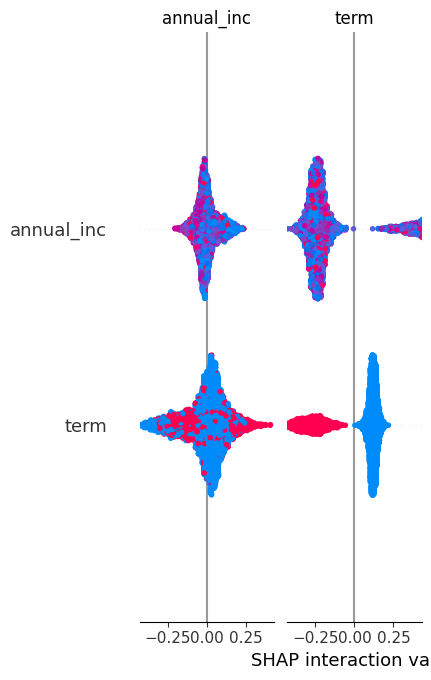

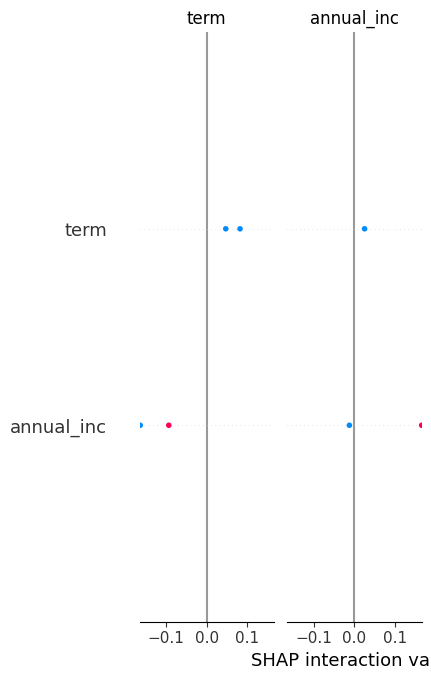

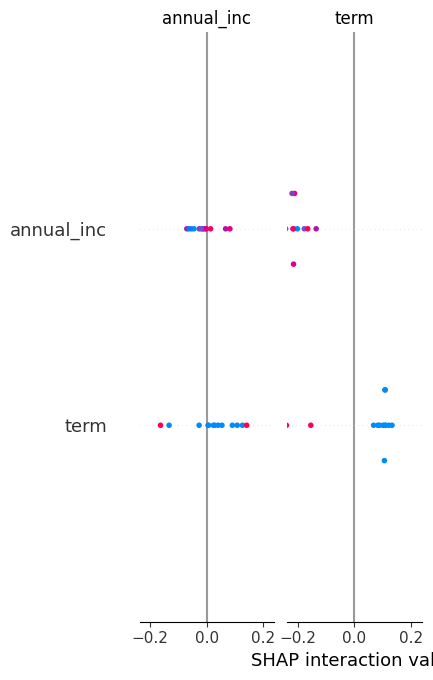

In [10]:
# Robust SHAP plotting block — paste and run this cell

import numpy as np
import pandas as pd
import shap

# Build DataFrame using the same feature names the model was trained on
X_df = pd.DataFrame(X, columns=aif_data.feature_names)

# Diagnostics: model's expected input dimension
model_n_features = getattr(rf, "n_features_in_", None)
print("Model reports n_features_in_ =", model_n_features)
print("X_df shape:", X_df.shape)

explainer = shap.TreeExplainer(rf)

# Compute raw SHAP values
raw_shap = explainer.shap_values(X_df)

# Normalise raw_shap to a 2D array (n_samples, n_features) for the class of interest
if isinstance(raw_shap, list):
    # multiclass or binary list: choose class 1 if available (positive class)
    if len(raw_shap) > 1:
        shap_arr = raw_shap[1]
        print("SHAP returned list; using index 1 (positive class).")
    else:
        shap_arr = raw_shap[0]
        print("SHAP returned single-item list; using element 0.")
else:
    shap_arr = raw_shap
    print("SHAP returned an array; using it directly.")

# If shap_arr still has an unexpected shape, try forcing computation on numpy array X
if hasattr(shap_arr, "ndim") and shap_arr.ndim == 1:
    print("Warning: shap_arr is 1-D; retrying explainer on numpy array.")
    raw_shap2 = explainer.shap_values(X)  # X is the numpy array used for training
    if isinstance(raw_shap2, list):
        shap_arr = raw_shap2[1] if len(raw_shap2) > 1 else raw_shap2[0]
    else:
        shap_arr = raw_shap2

# Final validation
n_samples, n_features = X_df.shape
if shap_arr.shape[0] != n_samples:
    raise ValueError(f"SHAP row count mismatch: shap rows={shap_arr.shape[0]} vs data rows={n_samples}")
if shap_arr.shape[1] != n_features:
    # Helpful diagnostics and fallback attempt
    print("SHAP column count:", shap_arr.shape[1], "vs X_df columns:", n_features)
    # Try computing SHAP on rf.predict_proba background if tree explainer gives different shape
    try:
        print("Attempting explainer on rf.feature_importances_ shaped input fallback...")
        # fallback: compute shap on X.values directly (already attempted above), else abort with guidance
        raise AssertionError("Feature count mismatch persists. Ensure rf was trained on the same features and in the same order as X_df.")
    except Exception as e:
        raise AssertionError(
            "SHAP feature-count mismatch. The most likely causes:\n"
            " - The RandomForest `rf` was trained on a different feature set/order than `X_df`.\n"
            " - One or more features were derived/dropped after training.\n\n"
            f"Details: {e}"
        )

# At this point shap_arr matches X_df columns — produce plots
print("SHAP array validated: shape", shap_arr.shape)

# Global summary (bar)
shap.summary_plot(shap_arr, X_df, plot_type="bar")

# Subgroup SHAP plots — privileged vs unprivileged
privileged_mask = X_df['zip_code'] == 1
unprivileged_mask = X_df['zip_code'] == 0

privileged_idx = np.where(privileged_mask)[0]
unprivileged_idx = np.where(unprivileged_mask)[0]

if privileged_idx.size > 0:
    shap.summary_plot(shap_arr[privileged_idx], X_df.iloc[privileged_idx])

if unprivileged_idx.size > 0:
    shap.summary_plot(shap_arr[unprivileged_idx], X_df.iloc[unprivileged_idx])


## Step 6: Save Results

In [ ]:
results = {
    'Accuracy': post_metrics['Accuracy'],
    'Precision': post_metrics['Precision'],
    'Recall': post_metrics['Recall'],
    'F1': post_metrics['F1'],
    'AUC': post_metrics['AUC'],
    'SPD': fairness_post['SPD'],
    'DI': fairness_post['DI'],
    'EOD': fairness_post['EOD'],
    'AOD': fairness_post['AOD'],
    'BiasAmp': fairness_post['Bias Amplification'],
    'Theil': fairness_post['Theil Index']
}

out_path = '/content/drive/MyDrive/Research_Thesis_Implementation/exp9_rf_roc_results.csv'
pd.DataFrame([results]).to_csv(out_path, index=False)
print('Saved results to:', out_path)